### Assessing the Biodiversity Intactness Index change in Phoenix subdivision 2017-2020
### Author: Flora Hamilton
### Repo Link: https://github.com/floraham/biodiv-index-phx/tree/main

## Context 

In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was
the US county that added the most developed land since 2001 [[1](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/)]. Urban sprawl
creates pressure on biodiversity and natural areas. In this task you will explore a
dataset showing values for a biodiversity intactness index (BII) [[2](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf), [3](https://planetarycomputer.microsoft.com/dataset/io-biodiversity)] to find changes
in this BII around the Phoenix area from 2017 to 2020.




## Data access:
##### Biological Intactness Index (BII) data: 
* This dataset is part of the MPC STAC catalog. You will need to access the `io-biodiversity` collection and look for the 2017 and 2020 rasters covering Phoenix subdivision. You can use the following coordinates for a bounding box:
[-112.826843, 32.974108, -111.184387, 33.863574]
##### Phoenix subdivision shapefile:
* The Phoenix subdivision polygon can be found in the Census County Subdivision shapefiles for Arizona:
https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions

## About the Datasets 
- Biological Intactness Index (BII): What is it? | [The original paper](https://www.nature.com/articles/nature03289)
> In 2005, the Biodiversity Intactness Index (BII) was introduced by R. J. Scholes & R. Biggs as an accessible and effective measure of biodiversity, designed for application at various spatial scales. The index gauges the average abundance of a diverse set of species relative to their reference populations, excluding non-native species. It gained prominence in the 2015 revision of the Planetary Boundaries framework, serving as an interim measure for biosphere integrity. The framework suggested that a BII reduction below 90% in a large region could pose a risk to ecosystem services and sustainable development, but the exact 'safe limit' for BII remained uncertain [1](https://adrianadepalma.github.io/BII_tutorial/bii_example.html). 



- TIGER Shape files, Phoenix Subdivision: Who creates it and where is it from? | [US Census TIGER/Line shapefiles website](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) 
> The U.S. Census Bureau creates TIGER (Topologically Integrated Geographic Encoding and Referencing) Line Shapefiles by collecting and editing geographic data from various sources, assigning attributes, and applying quality control measures. STIGER files do not contain the census demographic data, but merely the geospatial/map data and are often merged with demographic data and other spatially correlated variables to create analyses. 


### Import Relevant Libraries 

In [1]:
#importing the relevant libraries 

import numpy as np 
import geopandas as gpd
import rioxarray as rioxr 
import matplotlib.pyplot as plt 
import contextily as ctx # adding basemaps
import pandas as pd 
import matplotlib.patches as mpatches

from shapely.geometry import Polygon 


#used to access STAC catalogs# 
from pystac_client import Client 

#used to sign items from the MPC STAC catalog 
import planetary_computer

from IPython.display import Image 

## Access Biodiversity Data via Catalog

In [2]:
# bll data 
# access catalog 
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)


## Select data from area of interest 

In [3]:

# coords defining bbox around phoenix subdivision 
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search 
search = catalog.search(
    collections=["io-biodiversity"], 
    bbox=bbox, 
    datetime=['2017','2020']
)

# get items from search
items = search.item_collection()
print(f'There are {len(items)} items in the search.')

There are 4 items in the search.


In [4]:
#To get the items found in the search (or check if there were any matches in the search) we use the item_collection() method:
#This output tells us there were two items in the catalog that matched our search!

items

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


### Retrieve 2017 items 

In [37]:
# Item 2017
#Let’s get the first item in the search:

# get first item in the catalog search (year 2017) 
item2017 = items[0]
type(item2017)

#items[0].properties

item2017.properties
#asset = items.assets['data']


for key in item2017.assets.keys():
    print(key, '--', item2017.assets[key].title)
    

# plot rendered preview
Image(url=item2017.assets['rendered_preview'].href, width=500)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


### Retrieve 2020 items 

In [39]:
# Let's do the same thing with 2020 data
#Let’s get the first item in the search:

# get first item in the catalog search (year 2020) 
item2020 = items[3]
type(item2020)

#items[0].properties

item2020.properties
#asset = items.assets['data']


for key in item2020.assets.keys():
    print(key, '--', item2020.assets[key].title)
    

# plot rendered preview
Image(url=item2020.assets['rendered_preview'].href, width=500)


data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


## Prepare Phoenix County data For Plotting

Subset for Phoenix County Shapefile 

<Axes: >

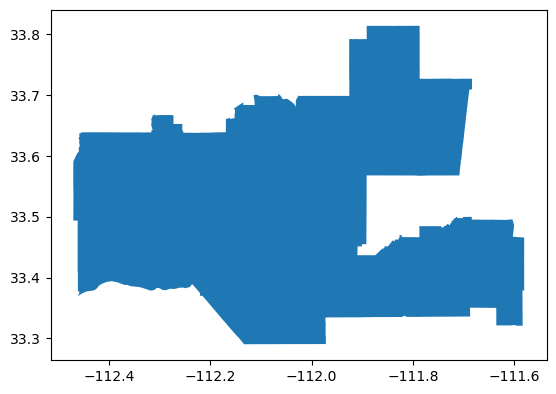

In [7]:
arizona = gpd.read_file("~/biodiv-index-phx/data/tl_2022_04_cousub.shp")
phoenix = arizona[arizona['NAME']== "Phoenix"]

phoenix.plot()

### Create a map showing the Phoenix subdivision within an appropriate geographical context.

We use the contextily package to create a basemap to set the geographical context 

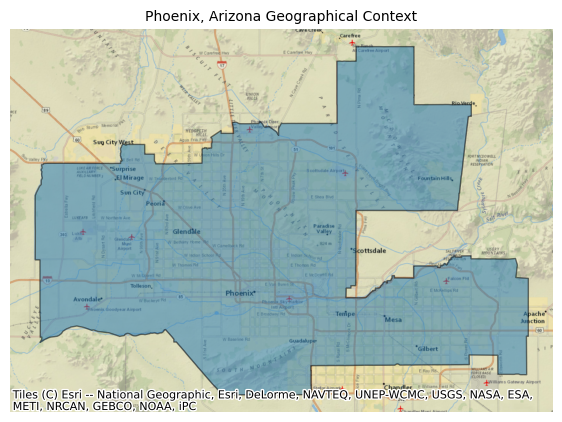

In [8]:
# create axis with plot
ax = (phoenix.to_crs(epsg=3857) ## change phoenix crs to basemap crs
      .plot(figsize=(7, 7), 
            alpha=0.5, 
            edgecolor="k")
      )

# add NatGeo basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix, Arizona Geographical Context", fontdict={"fontsize": "10"})

ax.set_axis_off()

### Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017. Obtain the same calculation for 2020.



- Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’.


- To calculate the percentage area: (pixels in class)/(total pixels) * 100.

#### First, we need to standardize the raster / crs to be the same one. I've chosen to transform the shapefile crs. 


EPSG:4326 4326 4326


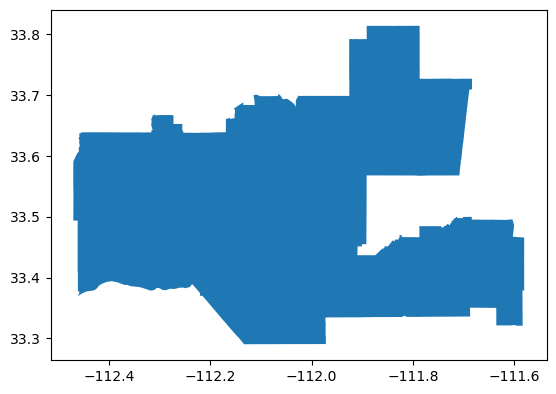

In [9]:

#check crs of shape file and raster 
#crs of the raster: EPSG 4326
item2017.properties['proj:epsg']
item2020.properties['proj:epsg']


#crs of the shapefile: EPSG 4269
phoenix.plot()

#convert crs of phoenix shapefile to raster 
phoenix = phoenix.to_crs(epsg = 4326)

#check cr's; they're all the same now. 
print(phoenix.crs, item2017.properties['proj:epsg'], item2020.properties['proj:epsg'])



In [10]:
#convert them into xarray.DataArray.... maybe we do this after we have clipped 

item2017_df = rioxr.open_rasterio(item2017.assets['data'].href)
item2020_df = rioxr.open_rasterio(item2020.assets['data'].href)


In [11]:
#create a mask / clip 
phx_2017 = item2017_df.rio.clip(phoenix.geometry)
phx_2020 = item2020_df.rio.clip(phoenix.geometry)



Plot to verify that the raster was clipped 

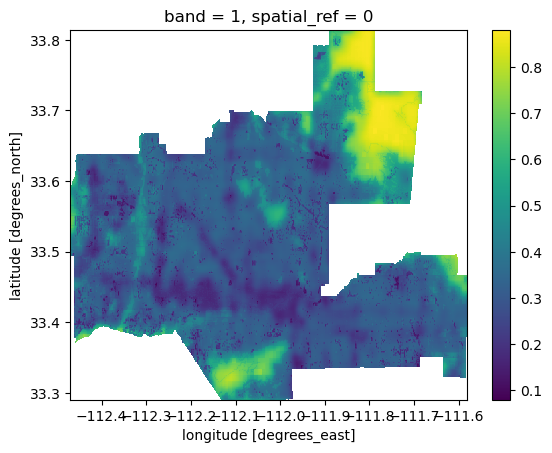

In [12]:
#check plot 
phx_2017.plot()
#phx_2020.plot()


check data types to confirm they're the desired data types 

In [13]:

##check data types to confirm they're now the desired data types
print(type(phx_2017) , type(phx_2020))



<class 'xarray.core.dataarray.DataArray'> <class 'xarray.core.dataarray.DataArray'>


Now, select area based on BII criteria. 

In [22]:

##selecting area based on BII criteria. We turn these into 1's so that we can calculate the number of pixels later. 
select_2017 = 1*(phx_2017 >= 0.75)
select_2020 = 1*(phx_2020 >= 0.75)


#- find the total pixels. Remember: To calculate the percentage area: (pixels in class)/(total pixels) * 100.
px_total_17 = np.unique(select_2017, return_counts=True)
px_total_20 = np.unique(select_2020, return_counts=True)

### Calculating the number of 1's pixels (pixels representing areas that pass the BII criteria) for 2017

In [33]:
px_counts_17 = np.unique(px_total_17, return_counts=True)


# initialize dictionary with columns' data 
pix_counts_total17 = {'BII' : px_total_17[0],
     'number_pixs' : px_total_17[1]
     }

# create data frame
pix_counts_total_17df = pd.DataFrame(pix_counts_total17)

pix_counts_total_17df

,BII,number_pixs
0,0,555184
1,1,21986


In [24]:
percentage_cover_17 =  (1 - (sum(pix_counts_total_17df.number_pixs) - pix_counts_total_17df.number_pixs[pix_counts_total_17df.index.max()])/sum(pix_counts_total_17df.number_pixs))* 100
print(round(percentage_cover_17,3), "% of the area in the Phoenix subdivision had a BII value of at least 0.75 in 2017")


3.809 % of the area in the Phoenix subdivision had a BII value of at least 0.75 in 2017


### And now the same for the year 2020

In [35]:
px_counts_20 = np.unique(px_total_20, return_counts=True)


# initialize dictionary with columns' data 
pix_counts_total20 = {'BII' : px_total_20[0],
     'number_pixs' : px_total_20[1]
     }

# create data frame
pix_counts_total_20df = pd.DataFrame(pix_counts_total20)

pix_counts_total_20df

,BII,number_pixs
0,0,553037
1,1,24133


In [26]:
percentage_cover_20 = (1 - (sum(pix_counts_total_20df.number_pixs) - pix_counts_total_20df.number_pixs[pix_counts_total_20df.index.max()])/sum(pix_counts_total_20df.number_pixs))*100

print(round(percentage_cover_20,3), "% of the area in the Phoenix subdivison had a BII value of at least 0.75 in 2020")

4.181 % of the area in the Phoenix subdivison had a BII value of at least 0.75 in 2020


### Summarize in words

In [32]:
change = percentage_cover_17 - percentage_cover_20
print("the difference between 2017 and 2020 in percentage cover was ", round(change,3) , " percent")

the difference between 2017 and 2020 in percentage cover was  -0.372  percent


## Visualizing the area with BII>=0.75 in 2017 that was lost by 2020. 

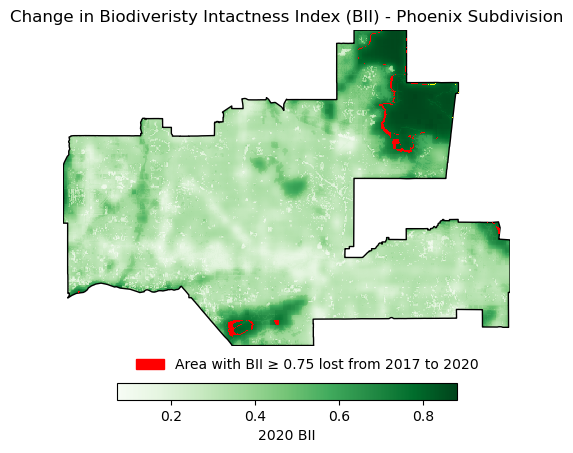

In [36]:
R3 = select_2017-select_2020

R3 = R3.squeeze().drop('band')

type(R3)
R3 = R3.where(R3 != 0, np.nan)



# Create a new figure
fig, ax = plt.subplots()

# Plot the first raster with its colorbar
im1 = phx_2020.plot(ax=ax, cmap='Greens', add_colorbar=False)
cbar1 = plt.colorbar(im1, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
cbar1.set_label('2020 BII')


# add outline of phoenix subdivision
phoenix.plot(ax = ax,
         color = "none",
         edgecolor = 'black')

    
# Rotate the colorbar label for the first raster
cbar1.ax.yaxis.label.set_rotation(270)  # Adjust the rotation angle 


# Plot the second raster without its colorbar
im2 = R3.plot(ax=ax, cmap="autumn", add_colorbar=False)
#setting the patch for difference raster 
R3_patches = mpatches.Patch(color='Red', label = "Area with BII ≥ 0.75 lost from 2017 to 2020") 



handles, labels = ax.get_legend_handles_labels() 
ax.legend(handles = [R3_patches], frameon= False, loc = (0.15,-0.1))


ax.axis('off')
ax.set_title('Change in Biodiveristy Intactness Index (BII) - Phoenix Subdivision')



# Show the plot. Voila! 
plt.show()